# Using Survey Data as a Predictor of Pandemic Vaccination
## 1 - EDA

### Mark Patterson, March 2021 

### Introduction
My Capstone project utilizes a multi-method approach to answer the following analysis questions: 
1. Can we use results of a public opinion survey to predict if people did or did not get an H1N1 vaccination? If so, how well can it predict?
2. What are the key factors that help predict if people did or did not get vaccinated?
3. Are there any other underlying patterns or groupings that can help us identify who did or did not get vaccinated?
4. And then linking this to the present… To improve chances of more people getting vaccinated, what questions about the COVID vaccine and vaccination need to be addressed? What are the concerns and misperceptions?
Each question / part of the analysis is contained in a seperate notebook. This is Notebook 1 and covers initial data inspection, cleaning, and EDA. 

### Import Libraries and Load Data

In [1]:
# Import the relevant libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

%matplotlib inline

# Increase column width to display df
pd.set_option('display.max_columns', None)

In [2]:
# Load the data - note that the Y variable was in a speerate CSV file. 
raw_data_x = pd.read_csv('data/training_set_features.csv')
raw_data_y = pd.read_csv('data/training_set_labels.csv')

# print the shape
print("Raw_data_x:", raw_data_x.shape)
print("Raw_data_y:", raw_data_y.shape)

Raw_data_x: (26707, 36)
Raw_data_y: (26707, 3)


In [3]:
raw_data_y.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [4]:
# Combine 2 original dataframes into one
raw_all = pd.merge(raw_data_x, raw_data_y, on="respondent_id", how="inner")
print(raw_all.shape)
raw_all.head()

(26707, 38)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


### Initial Data Inspection and Understanding

In [5]:
# General Info on the Data
print("--------------------------------------------")
print("Full, raw data set for Swine and Seasonal Vac Survey")
print("--------------------------------------------")
print(raw_all.shape)
print("--------------------------------------------")
print("Datatypes")
display(raw_all.info())
print("--------------------------------------------")
print("Columns with null values")
display(raw_all.isnull().sum())
print("--------------------------------------------")
print("--------------------------------------------")

--------------------------------------------
Full, raw data set for Swine and Seasonal Vac Survey
--------------------------------------------
(26707, 38)
--------------------------------------------
Datatypes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
respondent_id                  26707 non-null int64
h1n1_concern                   26615 non-null float64
h1n1_knowledge                 26591 non-null float64
behavioral_antiviral_meds      26636 non-null float64
behavioral_avoidance           26499 non-null float64
behavioral_face_mask           26688 non-null float64
behavioral_wash_hands          26665 non-null float64
behavioral_large_gatherings    26620 non-null float64
behavioral_outside_home        26625 non-null float64
behavioral_touch_face          26579 non-null float64
doctor_recc_h1n1               24547 non-null float64
doctor_recc_seasonal           24547 non-null float64
chronic_med_condition          2573

None

--------------------------------------------
Columns with null values


respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

--------------------------------------------
--------------------------------------------


#### Observations on the DataSet:
Quite a few features with missing values... some as high as 13,000 missing. This may necessitate dropping columns (employment and health_insurance); For some of the others... up to 4,400 missing (income level).

In [6]:
# Examine classes within each feature (gain an understanding of data and look for oddities)
for column in raw_all:
    unique_values = raw_all[column].value_counts()
    nr_values = len(unique_values)
    if nr_values <= 14:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for respondent_id is: 26707
values for h1n1_concern is: 4 -- 2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64
values for h1n1_knowledge is: 3 -- 1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64
values for behavioral_antiviral_meds is: 2 -- 0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64
values for behavioral_avoidance is: 2 -- 1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64
values for behavioral_face_mask is: 2 -- 0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64
values for behavioral_wash_hands is: 2 -- 1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64
values for behavioral_large_gatherings is: 2 -- 0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64
values for behavioral_outside_home is: 2 -- 0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64
values for behavioral_touch_face is: 2 -- 1.0    18001
0.0

In [7]:
# Check for duplicated rows - apprears to be NO duplicates
duplicate = raw_all[raw_all.duplicated()]
duplicate.shape

(0, 38)

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


<AxesSubplot:xlabel='h1n1_vaccine', ylabel='count'>

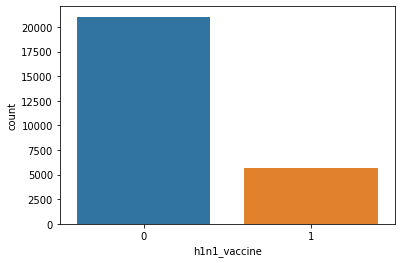

In [8]:
# Check our class balance for our target variable - primarily interested in H1N1 and less so the seasonal. 
print (raw_all['h1n1_vaccine'].value_counts())
sns.countplot(x = 'h1n1_vaccine', data = raw_all)

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


<AxesSubplot:xlabel='seasonal_vaccine', ylabel='count'>

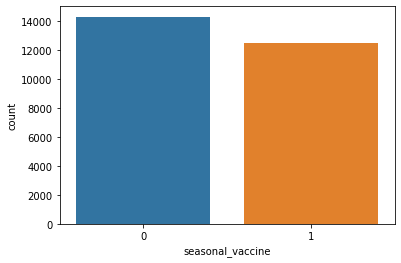

In [9]:
print (raw_all['seasonal_vaccine'].value_counts())
sns.countplot(x = 'seasonal_vaccine', data = raw_all)

<AxesSubplot:xlabel='h1n1_vaccine'>

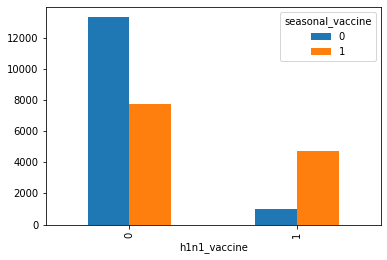

In [10]:
pd.crosstab(raw_all['h1n1_vaccine'],raw_all['seasonal_vaccine']).plot.bar()

<AxesSubplot:xlabel='seasonal_vaccine'>

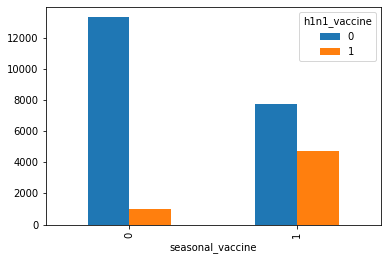

In [11]:
pd.crosstab(raw_all['seasonal_vaccine'],raw_all['h1n1_vaccine']).plot.bar()

#### Observations on the target variables
The incidence of having gotten the seasonal vacination is balanced No = 53% and Yes = 47% (12,435) The incidence for h1n1 vacination is quite unbalanced with No = 79% and Yes = 21% (5,674). May need to address this during modeling with SMOTE or other technique.

Looking at side by side plots above it is interesting that for the non h1n1 folk, about half of them DID get the seasonal vac. I wonder what role timing of the survey plays here. It is possible that some of these non-h1n1 vaccination folk may have been intending to get the vac but just hadnt yet?

### Continued Data Understanding - Group, Describe, Visualize
First I will break the features into conceptual groups (8). Then I will examine frequencies feature of the classes both in tables and plots. 

In [12]:
raw_all.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [13]:
# Creating 7 lists of conceptually similar features.
pcols_1 = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']
pcols_2 = ['opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc']
pcols_3 = ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_insurance']
pcols_4 = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask', 'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home','behavioral_touch_face']
pcols_5 = ['sex', 'age_group', 'education', 'race', 'marital_status']
pcols_6 = ['employment_status', 'health_worker', 'income_poverty', 'rent_or_own', 'employment_occupation', 'employment_industry']
pcols_7 = ['hhs_geo_region', 'census_msa', 'household_adults', 'household_children']

### Transform categorical text to numerical
Prior to ploting or creating summary tables, I will transform the remaining text values into numerical values. There are several options here. Based on some reading I just did, if I am going to use Decision Tree modeling, then it is suggested to NOT use one-hot encoding for this. Instead I will use OrdinalEncoder from sklearn to change the text values within a column to numerical values within the coulumn. This method still has a limitation of potential interpretation of ordered meaning between the values (which is appropriate for some of these features, but not all). A more manual alternative to this is to just assign the values myself through mapping via a dictionary of new numeric values.

In [145]:
raw_all.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,0.0,1.0,2.0,9.0,0.0,2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,9.0,0.0,1.0,0.0,wxleyezf,emcorrxb,0,0


In [14]:
raw_2 = raw_all

In [16]:
# Try the encoder on a couple of features.
encoder = OrdinalEncoder()
raw_2[['sex', 'race', 'age_group']] = encoder.fit_transform(raw_2[['sex', 'race', 'age_group']])
raw_2.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,< 12 Years,3.0,0.0,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,12 Years,3.0,1.0,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0.0,College Graduate,3.0,1.0,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4.0,12 Years,3.0,0.0,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2.0,Some College,3.0,0.0,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [19]:
raw_3 = raw_2

In [20]:
# Try the encoder on the rest of the non-Nan features.
encoder = OrdinalEncoder()
raw_3[['census_msa', 'hhs_geo_region']] = encoder.fit_transform(raw_3[['census_msa', 'hhs_geo_region']])
raw_3.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,< 12 Years,3.0,0.0,Below Poverty,Not Married,Own,Not in Labor Force,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,12 Years,3.0,1.0,Below Poverty,Not Married,Rent,Employed,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0.0,College Graduate,3.0,1.0,"<= $75,000, Above Poverty",Not Married,Own,Employed,9.0,0.0,2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4.0,12 Years,3.0,0.0,Below Poverty,Not Married,Rent,Not in Labor Force,5.0,1.0,0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2.0,Some College,3.0,0.0,"<= $75,000, Above Poverty",Married,Own,Employed,9.0,0.0,1.0,0.0,wxleyezf,emcorrxb,0,0


In [21]:
# Will use a manual map method for the remaining features ... change to numeric.
raw_3['marital_status'].value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [22]:
marital = {'Not Married': 0,'Married': 1,}
raw_3['marital_status'] = raw_3['marital_status'].map(marital)
raw_3.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,< 12 Years,3.0,0.0,Below Poverty,0.0,Own,Not in Labor Force,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,12 Years,3.0,1.0,Below Poverty,0.0,Rent,Employed,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [23]:
raw_3['rent_or_own'].value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

In [24]:
home = {'Rent': 0,'Own': 1}
raw_3['rent_or_own'] = raw_3['rent_or_own'].map(home)
raw_3.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,< 12 Years,3.0,0.0,Below Poverty,0.0,1.0,Not in Labor Force,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,12 Years,3.0,1.0,Below Poverty,0.0,0.0,Employed,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [25]:
raw_3['employment_status'].value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [26]:
emp = {'Unemployed': 0,'Not in Labor Force': 1,'Employed': 2}
raw_3['employment_status'] = raw_3['employment_status'].map(emp)
raw_3.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,< 12 Years,3.0,0.0,Below Poverty,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,12 Years,3.0,1.0,Below Poverty,0.0,0.0,2.0,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [27]:
raw_3['education'].value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [28]:
edu = {'< 12 Years': 0,'12 Years': 1,'Some College': 2,'College Graduate': 3}
raw_3['education'] = raw_3['education'].map(edu)
raw_3.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,Below Poverty,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,Below Poverty,0.0,0.0,2.0,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [29]:
raw_3['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [30]:
inc = {'Below Poverty': 0,'<= $75,000, Above Poverty': 1,'> $75,000': 2}
raw_3['income_poverty'] = raw_3['income_poverty'].map(inc)
raw_3.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1


In [31]:
raw_3['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [32]:
raw_3['employment_occupation'].value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

### Describe the Data with basic counts and stats
Will cycle through the 7 lists of conceptually similar features and look at freq counts and descriptive stats.

In [70]:
# Examine frequency of classes within each feature - for h1n1 vaccine target values
print('1-Concern, knowledge and opinions')
print('_____________________________________________________________')
for p in pcols_1:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

1-Concern, knowledge and opinions
_____________________________________________________________
h1n1_vaccine  h1n1_concern
0             2.0             38.660114
              1.0             32.237439
              3.0             15.507945
              0.0             13.594503
1             2.0             43.708024
              1.0             24.690703
              3.0             23.700954
              0.0              7.900318
Name: h1n1_concern, dtype: float64
---------------------------------------------------------
h1n1_vaccine  h1n1_knowledge
0             1.0               57.046659
              2.0               32.709298
              0.0               10.244042
1             1.0               46.939137
              2.0               46.673744
              0.0                6.387120
Name: h1n1_knowledge, dtype: float64
---------------------------------------------------------
h1n1_vaccine  opinion_h1n1_vacc_effective
0             4.0                            4

In [71]:
print('2-Seasonal opinions')
print('_____________________________________________________________')
for p in pcols_2:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

2-Seasonal opinions
_____________________________________________________________
h1n1_vaccine  opinion_seas_vacc_effective
0             4.0                            46.358225
              5.0                            33.378503
              2.0                             9.683976
              1.0                             5.478391
              3.0                             5.100905
1             5.0                            55.105697
              4.0                            36.725188
              2.0                             3.672519
              3.0                             2.902186
              1.0                             1.594411
Name: opinion_seas_vacc_effective, dtype: float64
---------------------------------------------------------
h1n1_vaccine  opinion_seas_risk
0             2.0                  36.569517
              1.0                  26.516658
              4.0                  25.677707
              5.0                   8.612579
      

In [72]:
print('3-Doctor and medical status')
print('_____________________________________________________________')
for p in pcols_3:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

3-Doctor and medical status
_____________________________________________________________
h1n1_vaccine  doctor_recc_h1n1
0             0.0                 86.729982
              1.0                 13.270018
1             1.0                 52.450355
              0.0                 47.549645
Name: doctor_recc_h1n1, dtype: float64
---------------------------------------------------------
h1n1_vaccine  doctor_recc_seasonal
0             0.0                     72.321335
              1.0                     27.678665
1             1.0                     51.357260
              0.0                     48.642740
Name: doctor_recc_seasonal, dtype: float64
---------------------------------------------------------
h1n1_vaccine  chronic_med_condition
0             0.0                      73.908319
              1.0                      26.091681
1             0.0                      63.437728
              1.0                      36.562272
Name: chronic_med_condition, dtype: float64
--

In [73]:
print('4-Behaviors')
print('_____________________________________________________________')
for p in pcols_4:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

4-Behaviors
_____________________________________________________________
h1n1_vaccine  behavioral_antiviral_meds
0             0.0                          95.569530
              1.0                           4.430470
1             0.0                          93.427812
              1.0                           6.572188
Name: behavioral_antiviral_meds, dtype: float64
---------------------------------------------------------
h1n1_vaccine  behavioral_avoidance
0             1.0                     71.454598
              0.0                     28.545402
1             1.0                     76.653076
              0.0                     23.346924
Name: behavioral_avoidance, dtype: float64
---------------------------------------------------------
h1n1_vaccine  behavioral_face_mask
0             0.0                     94.029496
              1.0                      5.970504
1             0.0                     89.661256
              1.0                     10.338744
Name: behavio

In [74]:
print('5-Main Demographics')
print('_____________________________________________________________')
for p in pcols_5:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

5-Main Demographics
_____________________________________________________________
h1n1_vaccine  sex
0             0.0    58.850378
              1.0    41.149622
1             0.0    61.332393
              1.0    38.667607
Name: sex, dtype: float64
---------------------------------------------------------
h1n1_vaccine  age_group
0             4.0          25.160462
              0.0          20.082727
              2.0          20.054201
              3.0          20.025674
              1.0          14.676936
1             4.0          27.335213
              3.0          23.810363
              2.0          17.976736
              0.0          17.465633
              1.0          13.412055
Name: age_group, dtype: float64
---------------------------------------------------------
h1n1_vaccine  education
0             3.0          38.286318
              2.0          28.053502
              1.0          23.764268
              0.0           9.895912
1             3.0          45.871051

In [75]:
print('6-Employment and Income')
print('_____________________________________________________________')
for p in pcols_6:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

6-Employment and Income
_____________________________________________________________
h1n1_vaccine  employment_status
0             2.0                  53.611209
              1.0                  40.260068
              0.0                   6.128723
1             2.0                  54.099574
              1.0                  41.513974
              0.0                   4.386452
Name: employment_status, dtype: float64
---------------------------------------------------------
h1n1_vaccine  health_worker
0             0.0              91.596721
              1.0               8.403279
1             0.0              78.535262
              1.0              21.464738
Name: health_worker, dtype: float64
---------------------------------------------------------
h1n1_vaccine  income_poverty
0             1.0               58.340021
              2.0               29.158546
              0.0               12.501433
1             1.0               53.720546
              2.0              

In [76]:
print('7-Household numbers')
print('_____________________________________________________________')
for p in pcols_7:
    print(raw_3.groupby('h1n1_vaccine')[p].value_counts(normalize=True)*100)
    print('---------------------------------------------------------')

7-Household numbers
_____________________________________________________________
h1n1_vaccine  hhs_geo_region
0             6.0               16.749869
              3.0               12.394808
              9.0               11.467694
              4.0               10.892407
              8.0               10.454999
              1.0               10.031855
              7.0                8.206152
              5.0                7.802025
              0.0                7.564304
              2.0                4.435886
1             6.0               13.641170
              1.0               12.971449
              9.0               12.160733
              8.0               11.632006
              3.0               11.596757
              4.0                9.992950
              7.0                9.111738
              0.0                7.789919
              5.0                7.701798
              2.0                3.401480
Name: hhs_geo_region, dtype: float64
------------

#### Observations on the distribution of feature classes
This is a bit cumbersome to look through. I think a better approach will be a visual one with plotting of the frequencies grouped by the target classes (0,1). See below for this. 

In [33]:
# Look at overall descriptive statistics
raw_3.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26707.000000,25300.000000,26707.000000,26707.000000,22284.000000,25299.000000,24665.000000,25244.000000,26707.000000,26707.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,2.186131,1.983162,2.570300,0.406223,1.184572,0.535792,0.759619,1.479599,4.829745,0.833489,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,1.457320,1.000787,0.923226,0.491136,0.626562,0.498727,0.427324,0.603916,2.805984,0.823313,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.000000,1.000000,1.000000,1.000000,2.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,7.000000,2.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,9.000000,2.000000,3.000000,3.000000,1.000000,1.000000


### Plotting the proportion of target class (stacked bars) for each class of each variable
This is basically a visual method for looking at the frequencise that I attemped to do above. Will cycle through the sets of features to plot every variable. 

In [146]:
# Take a look at one variable
counts = (raw_3[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine'))
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


In [147]:
# Change to proportion
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [148]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


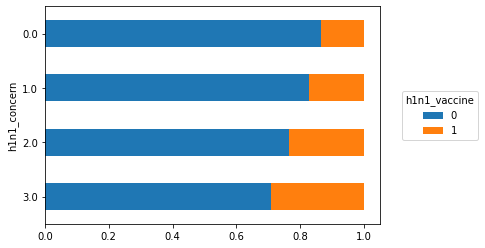

In [149]:
# Try using a stacked bar chart...
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine')

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: Matplotli

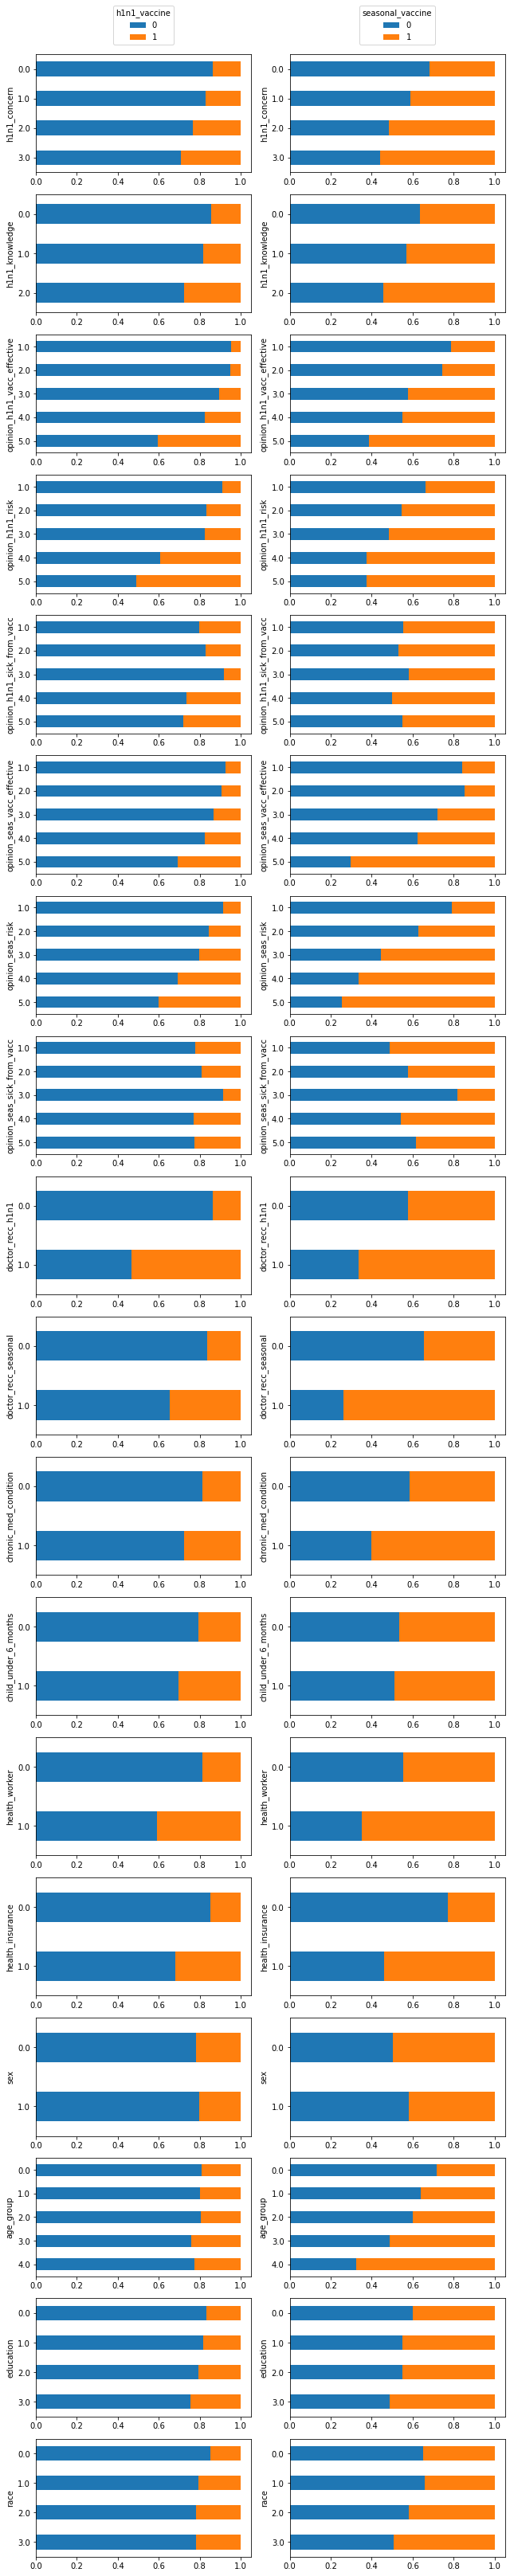

In [158]:
# Time to cycle throuh and Plot the first set of features. 
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'chronic_med_condition', 
    'child_under_6_months', 
    'health_worker',
    'health_insurance',
    'sex',
    'age_group',
    'education',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', raw_3, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', raw_3, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

In [156]:
raw_3.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: Matplotli

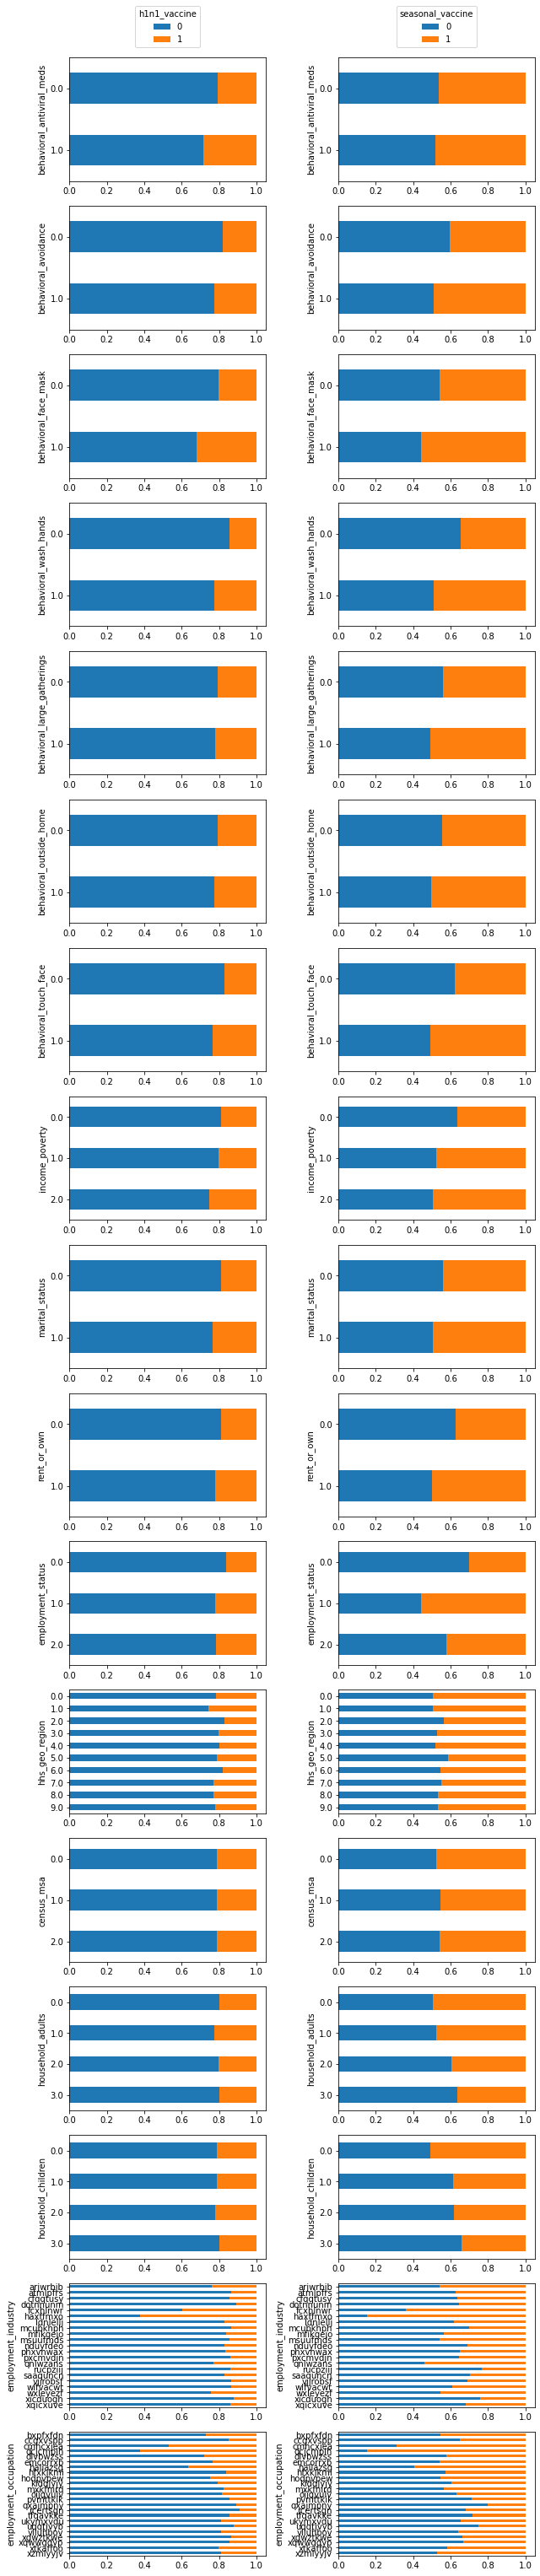

In [159]:
# Plot some MORE features - this is the second and final set. 
cols_to_plot = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation'
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', raw_3, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', raw_3, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

#### Observations on the class proportion plots for h1n1
NOTE: the proportion that got vaccinated (class 1) is in orange. The blue is the proportion that did not get vaccinated (class 0). The main differences we can see here are with the Opinion questions and the Doctor reccomend questions. There seem to be very little differences for the demographics (with the exection of employment occupation and industry and one geo location where differences are seen for just a few of the classes). 

In [42]:
# Take a more detailed look at descriptive stats for each variable - grouped by target(s)
# Loop through the descriptive statistices for each feature - h1n1 vaccine
print('1-Concern, knowledge, opinions')
print('_____________________________________________________________')
for p in pcols_1:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

1-Concern, knowledge, opinions
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20957.0  1.560815  0.910159  0.0  1.0  2.0  2.0  3.0
1              5658.0  1.832096  0.878564  0.0  1.0  2.0  2.0  3.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20939.0  1.224653  0.615697  0.0  1.0  1.0  2.0  2.0
1              5652.0  1.402866  0.606937  0.0  1.0  1.0  2.0  2.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20718.0  3.709576  1.016101  1.0  3.0  4.0  4.0  5.0
1             

In [43]:
print('2-Seasonal opinions')
print('_____________________________________________________________')
for p in pcols_2:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

2-Seasonal opinions
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20663.0  3.924745  1.122322  1.0  4.0  4.0  5.0  5.0
1              5582.0  4.400752  0.842616  1.0  4.0  5.0  5.0  5.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20621.0  2.533000  1.345229  1.0  1.0  2.0  4.0  5.0
1              5572.0  3.408112  1.310792  1.0  2.0  4.0  4.0  5.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20594.0  2.112314  1.322829  1.0  1.0  2.0  3.0  5.0
1              5576.0  2.

In [44]:
print('3-Doctor and medical status')
print('_____________________________________________________________')
for p in pcols_3:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

3-Doctor and medical status
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             19058.0  0.132700  0.339259  0.0  0.0  0.0  0.0  1.0
1              5489.0  0.524504  0.499445  0.0  0.0  1.0  1.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             19058.0  0.276787  0.447422  0.0  0.0  0.0  1.0  1.0
1              5489.0  0.513573  0.499861  0.0  0.0  1.0  1.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20244.0  0.260917  0.439145  0.0  0.0  0.0  1.0  1.0
1              54

In [45]:
print('4-Behaviors')
print('_____________________________________________________________')
for p in pcols_4:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

4-Behaviors
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20991.0  0.044305  0.205776  0.0  0.0  0.0  0.0  1.0
1              5645.0  0.065722  0.247817  0.0  0.0  0.0  0.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20858.0  0.714546  0.451641  0.0  0.0  1.0  1.0  1.0
1              5641.0  0.766531  0.423076  0.0  1.0  1.0  1.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             21020.0  0.059705  0.236945  0.0  0.0  0.0  0.0  1.0
1              5668.0  0.103387  

In [46]:
print('5-Main demographics')
print('_____________________________________________________________')
for p in pcols_5:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

5-Main demographics
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             21033.0  0.411496  0.492116  0.0  0.0  0.0  1.0  1.0
1              5674.0  0.386676  0.487031  0.0  0.0  0.0  1.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             21033.0  2.155042  1.460417  0.0  1.0  2.0  4.0  4.0
1              5674.0  2.301375  1.440068  0.0  1.0  3.0  4.0  4.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             19887.0  1.947302  1.006785  0.0  1.0  2.0  3.0  3.0
1              5413.0  2.

In [47]:
print('6-Employment and income')
print('_____________________________________________________________')
for p in pcols_6:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

6-Employment and income
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             19841.0  1.474825  0.609885  0.0  1.0  2.0  2.0  2.0
1              5403.0  1.497131  0.581191  0.0  1.0  2.0  2.0  2.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20373.0  0.084033  0.277444  0.0  0.0  0.0  0.0  1.0
1              5530.0  0.214647  0.410615  0.0  0.0  0.0  0.0  1.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             17446.0  1.166571  0.623599  0.0  1.0  1.0  2.0  2.0
1              4838.0

In [48]:
print('7-Household numbers')
print('_____________________________________________________________')
for p in pcols_7:
    print(raw_3.groupby('h1n1_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

7-Household numbers
_____________________________________________________________
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             21033.0  4.834593  2.782922  0.0  3.0  5.0  7.0  9.0
1              5674.0  4.811773  2.890046  0.0  3.0  5.0  7.0  9.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             21033.0  0.833310  0.823578  0.0  0.0  1.0  2.0  2.0
1              5674.0  0.834156  0.822406  0.0  0.0  1.0  2.0  2.0
-----------------------------------------------------------------------------
                count      mean       std  min  25%  50%  75%  max
h1n1_vaccine                                                      
0             20823.0  0.883542  0.760436  0.0  0.0  1.0  1.0  3.0
1              5635.0  0.

#### Observations on the comparative descriptive stats for h1n1
Beacuse the values are of a small range - in most cases 2 to 5, the quantiles are not very useful. I tried examining the means, but again this was not too easy. However, it corroborated what was seen in the plots above. I noted differences in the means > 0.10, and the variables with differences in the mean larger than this were the opinion questions, the doctor recommendation, and one of the behavioral questions. Only age group and education - in the demographic questions had mean differences above 0.10 (but not by much). 

In [50]:
# Loop through the descriptive statistices for each feature - SEASONAL VACCINE (although this is less important)
print('1-Concern, knowledge, opinions')
print('_____________________________________________________________')
for p in pcols_1:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

1-Concern, knowledge, opinions
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14222.0  1.486922  0.922611  0.0  1.0  2.0  2.0  3.0
1                 12393.0  1.769467  0.871893  0.0  1.0  2.0  2.0  3.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14212.0  1.193217  0.615942  0.0  1.0  1.0  2.0  2.0
1                 12379.0  1.342112  0.611079  0.0  1.0  1.0  2.0  2.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14029.0  3.657281  1.05

In [51]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('2-Sesonal opinions')
print('_____________________________________________________________')
for p in pcols_2:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

2-Sesonal opinions
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13987.0  3.657897  1.164812  1.0  3.0  4.0  4.0  5.0
1                 12258.0  4.445994  0.805401  1.0  4.0  5.0  5.0  5.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13959.0  2.213339  1.239794  1.0  1.0  2.0  3.0  5.0
1                 12234.0  3.296305  1.314729  1.0  2.0  4.0  4.0  5.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13931.0  2.194961  1.348964  1.0  1

In [52]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('3-Doctor and medical status')
print('_____________________________________________________________')
for p in pcols_3:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

3-Doctor and medical status
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 12873.0  0.141925  0.348987  0.0  0.0  0.0  0.0  1.0
1                 11674.0  0.306750  0.461164  0.0  0.0  0.0  1.0  1.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 12873.0  0.164453  0.370700  0.0  0.0  0.0  0.0  1.0
1                 11674.0  0.511992  0.499878  0.0  0.0  1.0  1.0  1.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13679.0  0.211273  0.40822

In [53]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('4-Behaviors')
print('_____________________________________________________________')
for p in pcols_4:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

4-Behaviors
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14249.0  0.047582  0.212888  0.0  0.0  0.0  0.0  1.0
1                 12387.0  0.050295  0.218561  0.0  0.0  0.0  0.0  1.0
-----------------------------------------------------------------------------
                    count      mean      std  min  25%  50%  75%  max
seasonal_vaccine                                                     
0                 14164.0  0.693801  0.46093  0.0  0.0  1.0  1.0  1.0
1                 12335.0  0.762140  0.42579  0.0  1.0  1.0  1.0  1.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14264.0  0.057137  0.232112  0.0  0.0  0.0  0.

In [54]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('5-Main demographics')
print('_____________________________________________________________')
for p in pcols_5:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

5-Main demographics
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14272.0  0.441564  0.496591  0.0  0.0  0.0  1.0  1.0
1                 12435.0  0.365661  0.481635  0.0  0.0  0.0  1.0  1.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14272.0  1.808716  1.413316  0.0  0.0  2.0  3.0  4.0
1                 12435.0  2.619300  1.384842  0.0  2.0  3.0  4.0  4.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13407.0  1.918252  1.010994  0.0  

In [55]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('6-Employment and income')
print('_____________________________________________________________')
for p in pcols_6:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

6-Employment and income
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13376.0  1.510242  0.633672  0.0  1.0  2.0  2.0  2.0
1                 11868.0  1.445062  0.566559  0.0  1.0  1.0  2.0  2.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 13776.0  0.074260  0.262202  0.0  0.0  0.0  0.0  1.0
1                 12127.0  0.154696  0.361630  0.0  0.0  0.0  0.0  1.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 11832.0  1.144354  0.643521  0

In [56]:
# Loop through the descriptive statistices for each feature - seasonal vaccine
print('7-Household numbers')
print('_____________________________________________________________')
for p in pcols_7:
    print(raw_3.groupby('seasonal_vaccine')[p].describe())
    print('-----------------------------------------------------------------------------')

7-Household numbers
_____________________________________________________________
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14272.0  4.878153  2.775398  0.0  3.0  5.0  7.0  9.0
1                 12435.0  4.774186  2.839777  0.0  3.0  5.0  7.0  9.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14272.0  0.847534  0.822066  0.0  0.0  1.0  2.0  2.0
1                 12435.0  0.817370  0.824481  0.0  0.0  1.0  2.0  2.0
-----------------------------------------------------------------------------
                    count      mean       std  min  25%  50%  75%  max
seasonal_vaccine                                                      
0                 14087.0  0.932278  0.780158  0.0  

#### Observations on the comparative means for seasonal
As this is less important, skipping for now.

### T-tests for each variable
We see that there are some differences in means, but are they significantly different? Will loop though T-Tests for each variable (using Welch's T-test). I found that the T-test did not like missing values, so used the data set after it had been imputed. 

In [122]:
# Load the data
df1_imputed = pd.read_csv('data/df1imputed.csv')
df1_imputed.shape

(26707, 37)

In [123]:
df1_imputed.head()

,Unnamed: 0,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,4.8,0.0,0.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,0.0,1.0,2.0,9.0,0.0,2.0,0.0,9.0,0.0,0.0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,5.0,0.0,1.0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8,3.0,3.0,2.0,3.0,1.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0


In [124]:
h1_vacc_Y = df1_imputed[(df1_imputed['h1n1_vaccine'] == 1)]
h1_vacc_N = df1_imputed[(df1_imputed['h1n1_vaccine'] == 0)]

In [119]:
from scipy import stats

In [125]:
# Try one test first...
# Check for statistically different means; had tried with raw_3 but did not work - maybe not like the missing values?
stats.ttest_ind(h1_vacc_Y['opinion_h1n1_risk'], h1_vacc_N['opinion_h1n1_risk'], equal_var=False)

Ttest_indResult(statistic=51.67045369051645, pvalue=0.0)

In [128]:
# Loop through the T-test for each feature - by group of features - h1n1 (0,1)
print('1-H1N1 concern, knowledge and opinions')
print('_____________________________________________________________')
for p in pcols_1:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

1-H1N1 concern, knowledge and opinions
_____________________________________________________________
Ttest_indResult(statistic=20.510686913663324, pvalue=1.8596981908676164e-91)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=19.56410490012085, pvalue=1.6236291632798846e-83)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=53.09553619943674, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=51.67045369051645, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=11.729537749716494, pvalue=1.5815353523327127e-31)
-----------------------------------------------------------------------------


In [129]:
print('2-Seasonal opinions')
print('_____________________________________________________________')
for p in pcols_2:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

2-Seasonal opinions
_____________________________________________________________
Ttest_indResult(statistic=35.21984765090239, pvalue=2.4069850414652085e-258)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=44.38540555296442, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=1.355953453780671, pvalue=0.17514904923807695)
-----------------------------------------------------------------------------


In [130]:
print('3-Doctor and medical status')
print('_____________________________________________________________')
for p in pcols_3:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

3-Doctor and medical status
_____________________________________________________________
Ttest_indResult(statistic=55.234149886505556, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=32.50356870676048, pvalue=4.820383492899826e-218)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=14.944208612507946, pvalue=7.431157595802916e-50)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=9.674613092878907, pvalue=5.144858926991929e-22)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=17.744089993769776, pvalue=1.7826917129231177e-69)
-----------------------------------------------------------------------------


In [131]:
print('4-Behaviors')
print('_____________________________________________________________')
for p in pcols_4:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

4-Behaviors
_____________________________________________________________
Ttest_indResult(statistic=6.001935291982516, pvalue=2.0357121771835943e-09)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.21325756203957, pvalue=2.435148211200556e-16)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=10.029519434985524, pvalue=1.5812416290564715e-23)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=13.611787397245248, pvalue=7.678192938010269e-42)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=2.847603227229391, pvalue=0.004415088522494424)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=3.482172901188056, pvalue=0.0004997645940054413)
-----------------------------------------------------------------------------
Ttest_

In [132]:
print('5-Main demographics')
print('_____________________________________________________________')
for p in pcols_5:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

5-Main demographics
_____________________________________________________________
Ttest_indResult(statistic=-3.399100994792271, pvalue=0.0006789974280048363)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=6.77223070168082, pvalue=1.3469184654694845e-11)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=11.54814586283158, pvalue=1.2243980625194762e-30)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=7.228957922227945, pvalue=5.223532819123491e-13)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.149205441348807, pvalue=4.150866095460693e-16)
-----------------------------------------------------------------------------


In [135]:
pcols_6 = ['employment_status', 'health_worker', 'income_poverty', 'rent_or_own', 'employment_industry']

In [136]:
print('6-Employment and income')
print('_____________________________________________________________')
for p in pcols_6:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

6-Employment and income
_____________________________________________________________
Ttest_indResult(statistic=2.3873789654572883, pvalue=0.016988860986239508)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=22.561790443788293, pvalue=6.307858068833229e-109)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.815132799670584, pvalue=1.4235812653389587e-18)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=5.772176775345721, pvalue=8.074945563152783e-09)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=-22.041654467274732, pvalue=8.484647447584251e-105)
-----------------------------------------------------------------------------


In [134]:
print('7-Household numbers')
print('_____________________________________________________________')
for p in pcols_7:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

7-Household numbers
_____________________________________________________________
Ttest_indResult(statistic=-0.5319629611849604, pvalue=0.5947652027440007)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=0.06876337454170406, pvalue=0.9451795028677601)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=1.1961309633662738, pvalue=0.23167598896085778)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=-0.5485111399441805, pvalue=0.5833545129411885)
-----------------------------------------------------------------------------


#### Observations on the h1n1 T-tests
Was suprised to see that almost all of the features had significantly different means. Th only 5 features did not have significanly differnct means - the opinion_seasonal_sick_from_vacc; and some demographics questions like number of household adults and children, and some of the location features.

#### Run T-test for the Seasonal values as well...

In [137]:
seasonal_vacc_Y = df1_imputed[(df1_imputed['seasonal_vaccine'] == 1)]
seasonal_vacc_N = df1_imputed[(df1_imputed['seasonal_vaccine'] == 0)]

In [138]:
# Loop through the T-test for each feature - by group of features - SEASONAL (0,1)
print('1-SEASONAL: H1N1 concern, knowledge and opinions')
print('_____________________________________________________________')
for p in pcols_1:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

1-SEASONAL: H1N1 concern, knowledge and opinions
_____________________________________________________________
Ttest_indResult(statistic=20.510686913663324, pvalue=1.8596981908676164e-91)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=19.56410490012085, pvalue=1.6236291632798846e-83)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=53.09553619943674, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=51.67045369051645, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=11.729537749716494, pvalue=1.5815353523327127e-31)
-----------------------------------------------------------------------------


In [139]:
print('2-SEASONAL: Seasonal opinions')
print('_____________________________________________________________')
for p in pcols_2:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

2-SEASONAL: Seasonal opinions
_____________________________________________________________
Ttest_indResult(statistic=35.21984765090239, pvalue=2.4069850414652085e-258)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=44.38540555296442, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=1.355953453780671, pvalue=0.17514904923807695)
-----------------------------------------------------------------------------


In [140]:
print('3-SEASONAL: Doctor and medical status')
print('_____________________________________________________________')
for p in pcols_3:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

3-SEASONAL: Doctor and medical status
_____________________________________________________________
Ttest_indResult(statistic=55.234149886505556, pvalue=0.0)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=32.50356870676048, pvalue=4.820383492899826e-218)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=14.944208612507946, pvalue=7.431157595802916e-50)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=9.674613092878907, pvalue=5.144858926991929e-22)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=17.744089993769776, pvalue=1.7826917129231177e-69)
-----------------------------------------------------------------------------


In [141]:
print('4-SEASONAL: Behaviors')
print('_____________________________________________________________')
for p in pcols_4:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

4-SEASONAL: Behaviors
_____________________________________________________________
Ttest_indResult(statistic=6.001935291982516, pvalue=2.0357121771835943e-09)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.21325756203957, pvalue=2.435148211200556e-16)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=10.029519434985524, pvalue=1.5812416290564715e-23)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=13.611787397245248, pvalue=7.678192938010269e-42)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=2.847603227229391, pvalue=0.004415088522494424)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=3.482172901188056, pvalue=0.0004997645940054413)
--------------------------------------------------------------------------

In [142]:
print('5-SEASONAL: Main demographics')
print('_____________________________________________________________')
for p in pcols_5:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

5-SEASONAL: Main demographics
_____________________________________________________________
Ttest_indResult(statistic=-3.399100994792271, pvalue=0.0006789974280048363)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=6.77223070168082, pvalue=1.3469184654694845e-11)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=11.54814586283158, pvalue=1.2243980625194762e-30)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=7.228957922227945, pvalue=5.223532819123491e-13)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.149205441348807, pvalue=4.150866095460693e-16)
-----------------------------------------------------------------------------


In [143]:
print('6-SEASONAL: Employment and income')
print('_____________________________________________________________')
for p in pcols_6:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

6-SEASONAL: Employment and income
_____________________________________________________________
Ttest_indResult(statistic=2.3873789654572883, pvalue=0.016988860986239508)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=22.561790443788293, pvalue=6.307858068833229e-109)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=8.815132799670584, pvalue=1.4235812653389587e-18)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=5.772176775345721, pvalue=8.074945563152783e-09)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=-22.041654467274732, pvalue=8.484647447584251e-105)
-----------------------------------------------------------------------------


In [144]:
print('7-SEASONAL: Household numbers')
print('_____________________________________________________________')
for p in pcols_7:
    print(stats.ttest_ind(h1_vacc_Y[p], h1_vacc_N[p], equal_var=False))
    print('-----------------------------------------------------------------------------')

7-SEASONAL: Household numbers
_____________________________________________________________
Ttest_indResult(statistic=-0.5319629611849604, pvalue=0.5947652027440007)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=0.06876337454170406, pvalue=0.9451795028677601)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=1.1961309633662738, pvalue=0.23167598896085778)
-----------------------------------------------------------------------------
Ttest_indResult(statistic=-0.5485111399441805, pvalue=0.5833545129411885)
-----------------------------------------------------------------------------


### Distplots to visualize the comparative values for h1n1 vaccine status
This is another method for trying to see differences between the target classes (0 = not vaccinated - in blue versus 1 = vaccinated - in orange) and the frequencies of each class. Again, I looped through all of the features by conceptual groups. 

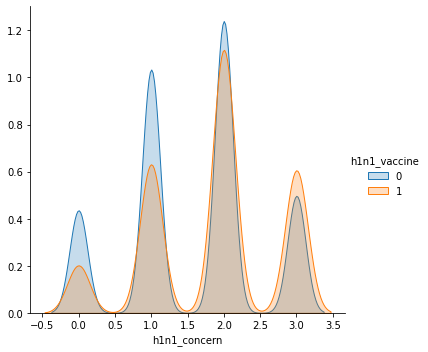

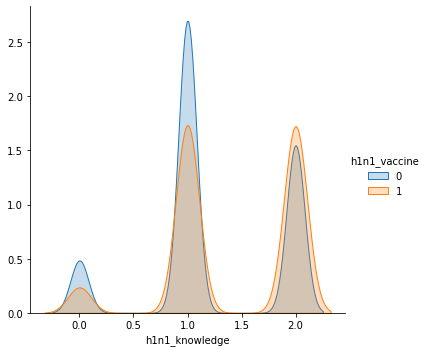

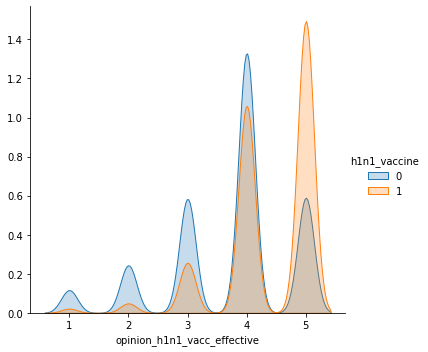

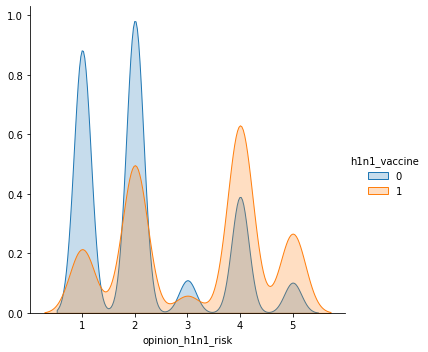

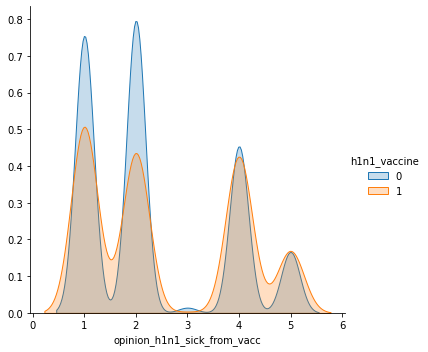

In [77]:
for p in pcols_1:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

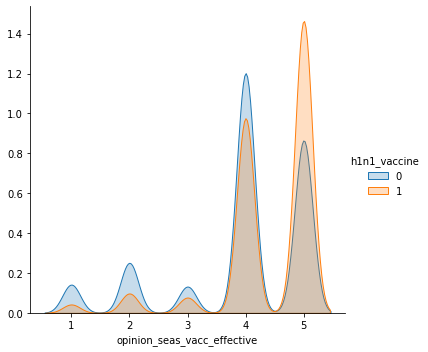

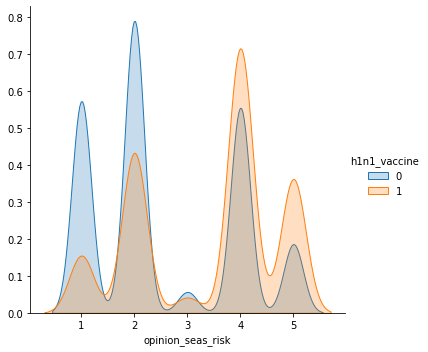

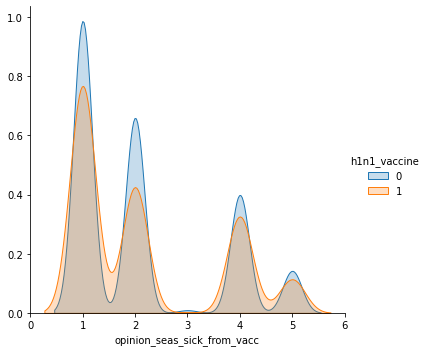

In [78]:
for p in pcols_2:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

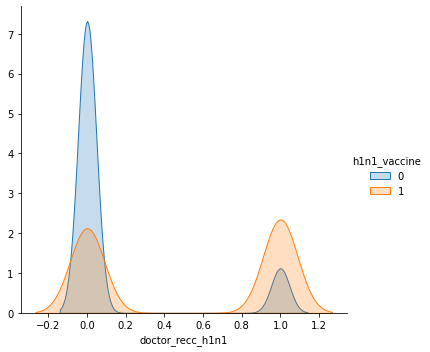

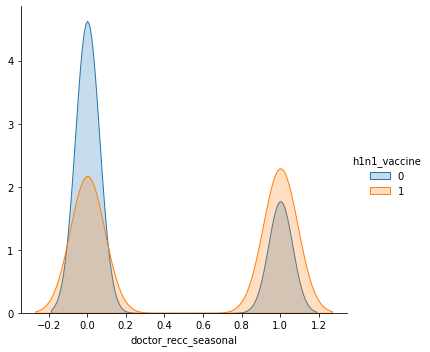

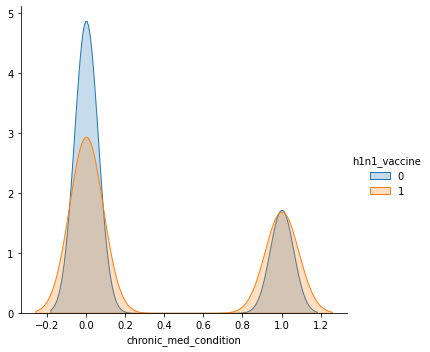

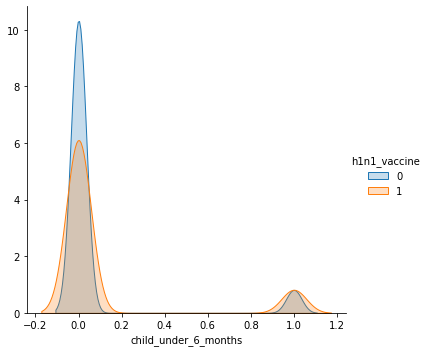

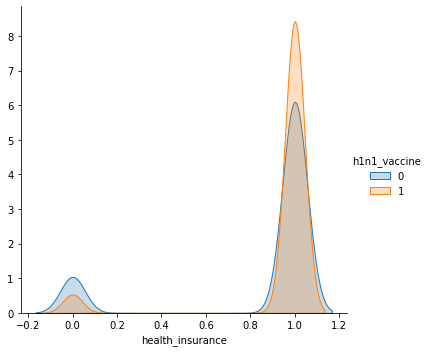

In [79]:
for p in pcols_3:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

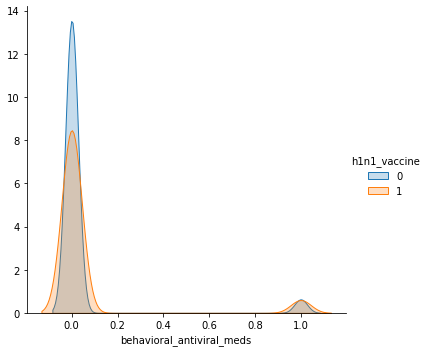

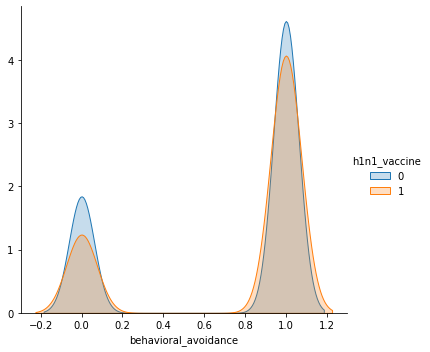

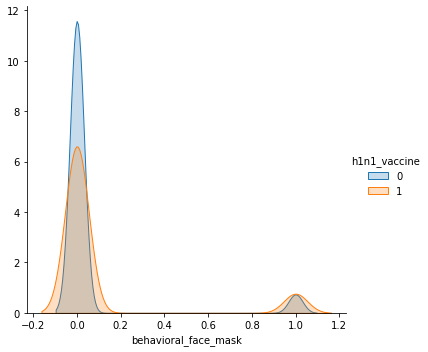

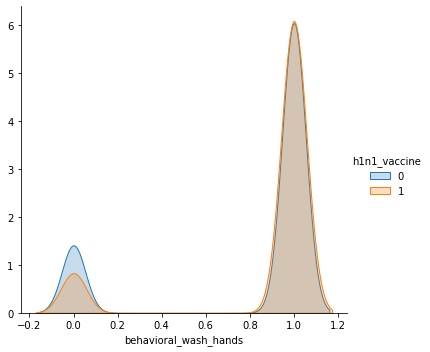

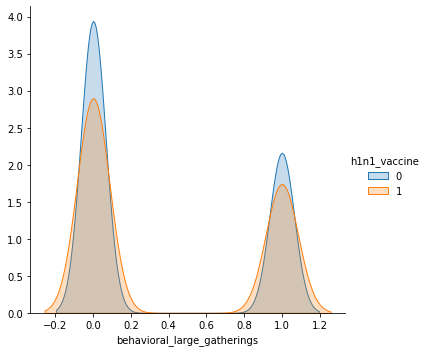

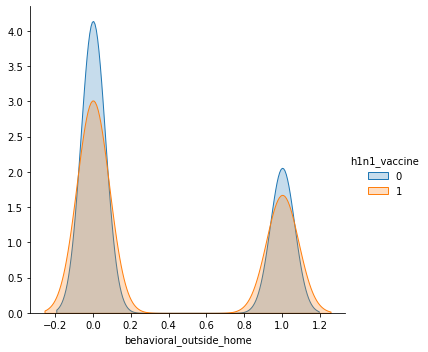

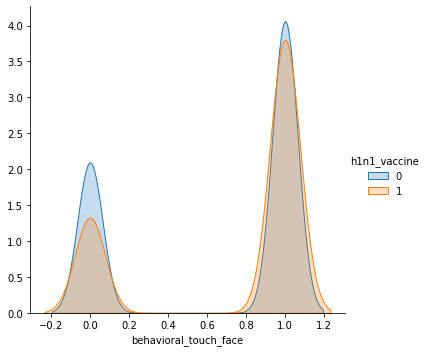

In [80]:
for p in pcols_4:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

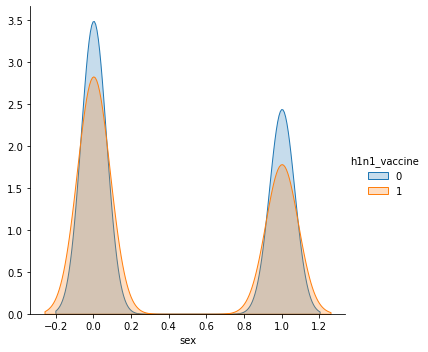

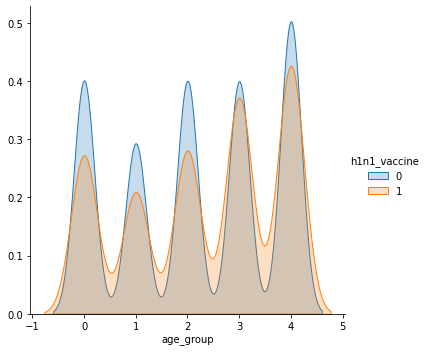

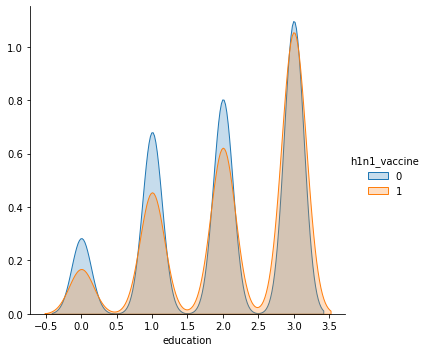

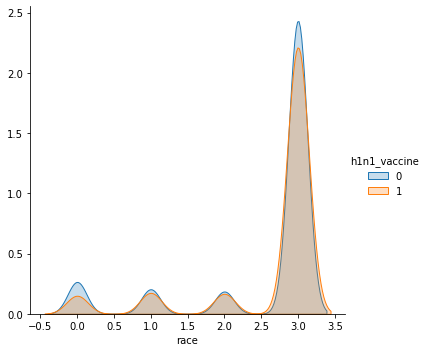

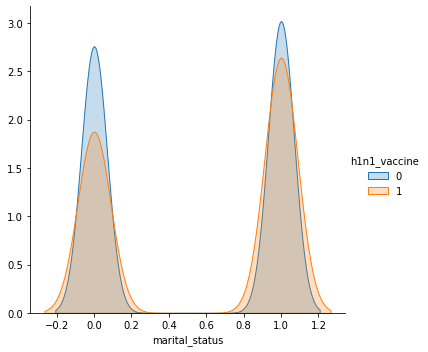

In [81]:
for p in pcols_5:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

In [84]:
# Issues with the pcols_6 due to inclusion of text in 2 features so cut those out.
pcols_6b = ['employment_status', 'health_worker', 'income_poverty', 'rent_or_own']

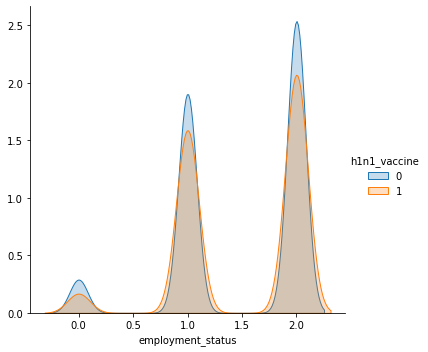

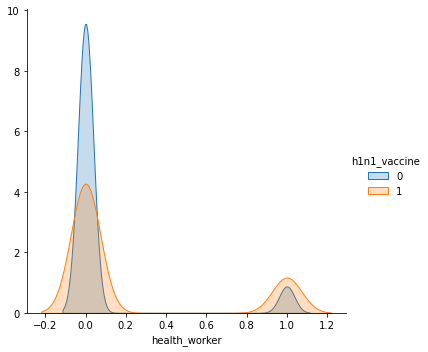

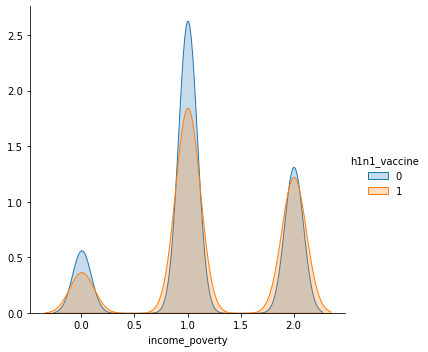

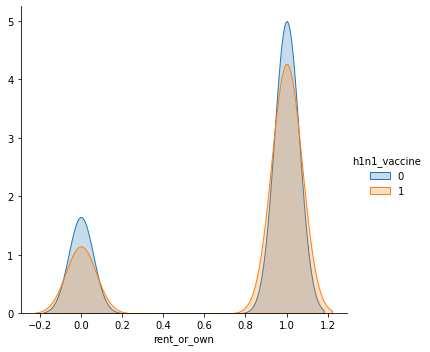

In [85]:
for p in pcols_6b:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

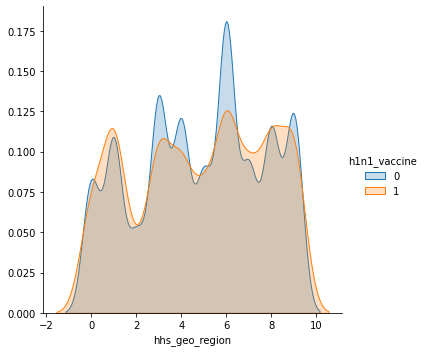

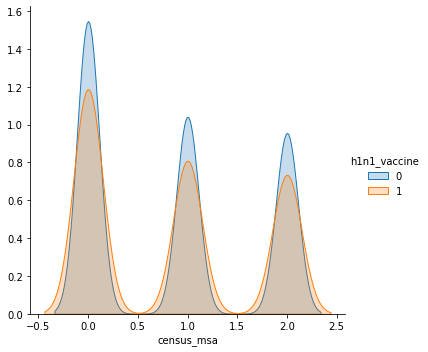

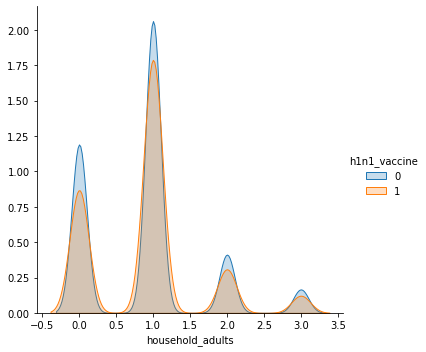

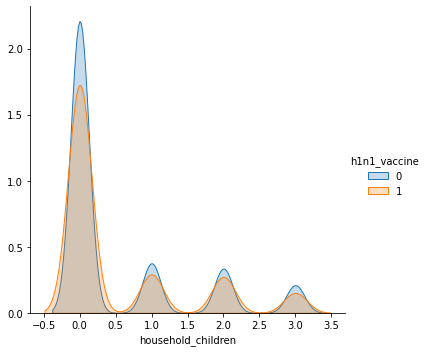

In [83]:
for p in pcols_7:
    (sns.FacetGrid(raw_3, hue='h1n1_vaccine',height=5).map(sns.kdeplot, p, shade=True).add_legend())

<AxesSubplot:xlabel='h1n1_vaccine'>

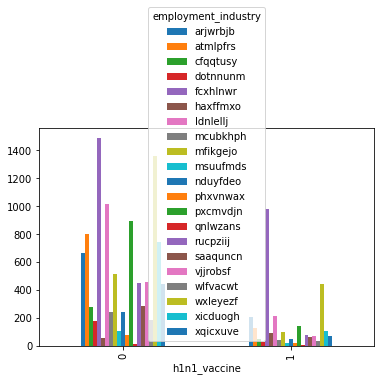

In [87]:
# Alternative plot for employment variables? 
pd.crosstab(raw_3['h1n1_vaccine'],raw_3['employment_industry']).plot.bar()

<AxesSubplot:xlabel='h1n1_vaccine'>

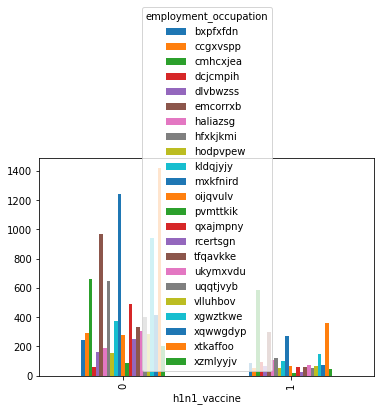

In [88]:
pd.crosstab(raw_3['h1n1_vaccine'],raw_3['employment_occupation']).plot.bar()

#### Observations on the distribution plots
This corroborated what we saw in the earlier plots. The largest differences between or target classes appear for the opinion questions / features and a few of the health / doctor related variables. Overall, it is appearing that there is adequate variation between the target variable classes to get some meaningful classification modeling results. 

### Look at correlations for each feature
Curious to see the level of correlation between each of the features. 

In [ ]:
# Moving this listing of feature groups here for easy reference: 
# Creating 7 lists of conceptually similar features.
pcols_1 = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']
pcols_2 = ['opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc']
pcols_3 = ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_insurance']
pcols_4 = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask', 'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home','behavioral_touch_face']
pcols_5 = ['sex', 'age_group', 'education', 'race', 'marital_status']
pcols_6 = ['employment_status', 'health_worker', 'income_poverty', 'rent_or_own', 'employment_occupation', 'employment_industry']
pcols_7 = ['hhs_geo_region', 'census_msa', 'household_adults', 'household_children']

<AxesSubplot:>

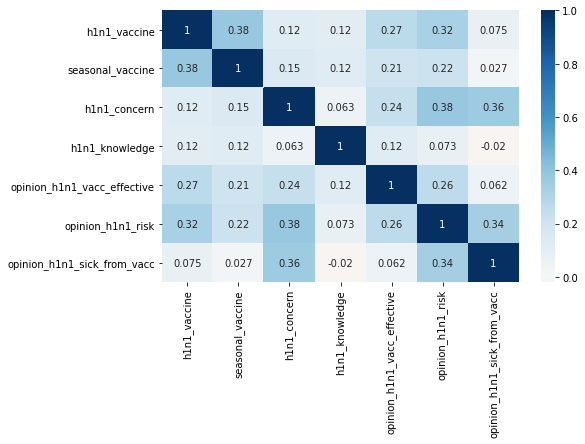

In [91]:
# Examine correlations via small groups / df - including the 2 target variables within each.
corr1 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr1, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

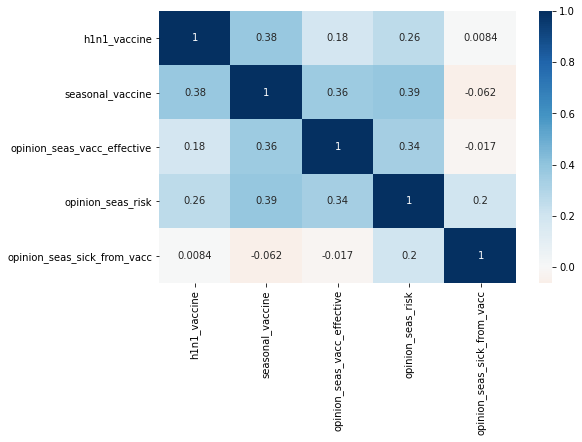

In [94]:
corr2 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr2, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

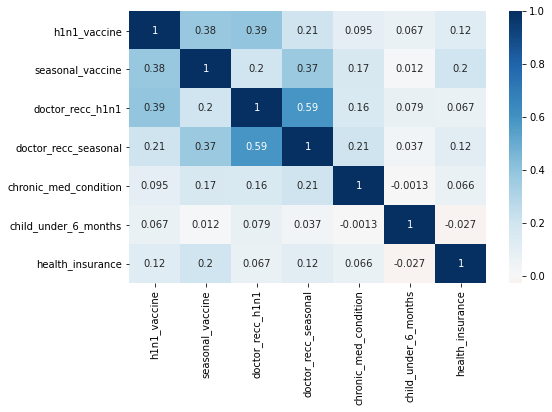

In [95]:
corr3 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_insurance']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr3, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

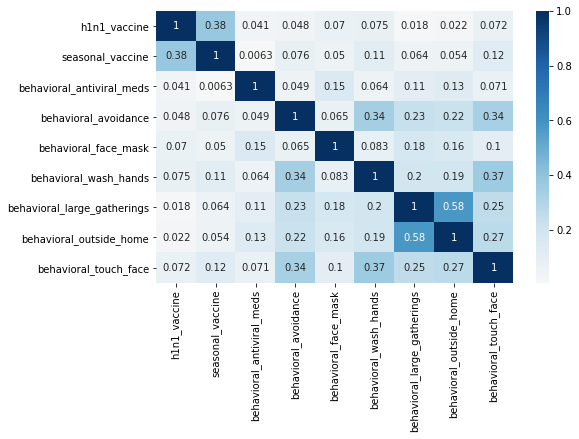

In [96]:
corr4 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask', 'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home','behavioral_touch_face']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr4, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

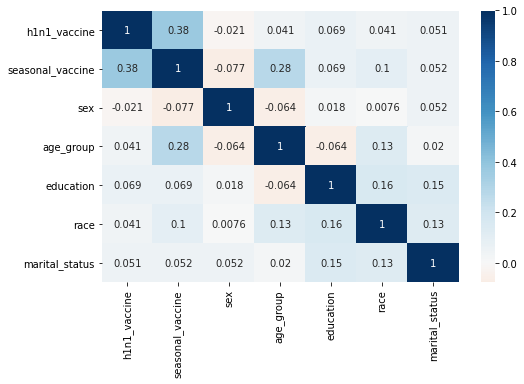

In [97]:
corr5 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'sex', 'age_group', 'education', 'race', 'marital_status']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr5, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

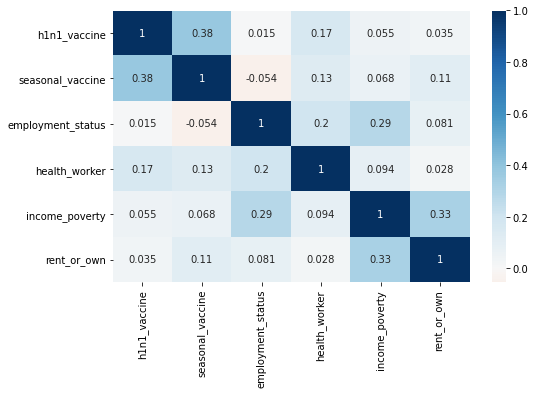

In [98]:
corr6 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'employment_status', 'health_worker', 'income_poverty', 'rent_or_own', 'employment_occupation', 'employment_industry']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr6, cmap='RdBu', annot=True, center=0)

<AxesSubplot:>

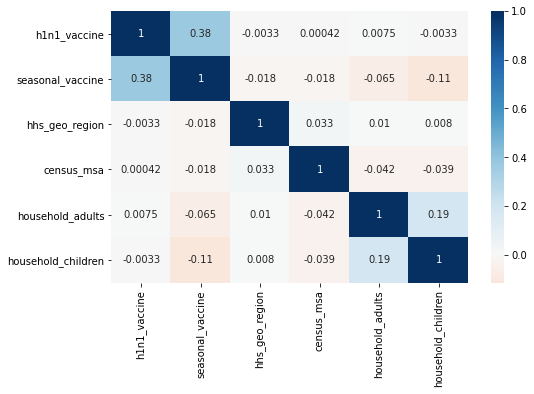

In [99]:
corr7 = raw_3[['h1n1_vaccine', 'seasonal_vaccine', 'hhs_geo_region', 'census_msa', 'household_adults', 'household_children']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr7, cmap='RdBu', annot=True, center=0)

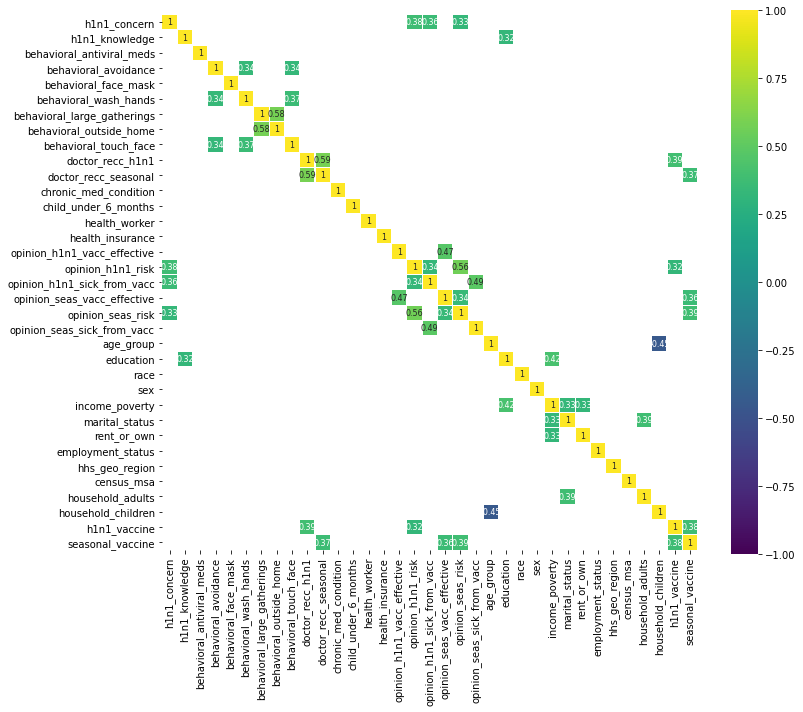

In [117]:
# Try this alternative version of correlation grid where a correlation value can be set and only those above that are shown. 
corr = raw_3.drop('respondent_id', axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Observations on the correlation matrices
Most of the correlation values were fairly low. Only 2 variables had a correlation with the target varialble greater than 0.30 and that was opinion_h1n1_risk (0.32) and doctor_recc_h1n1 (0.39). And even looking at correlations with features other than the target, only 2 variables were above 0.50 = doctor_recc_h1n1 and doctor_recc_seasonal (0.59) and behavioral_large_gatherings and behavioral_outside_home (0.58). There were a hndful of others with correlation values in the 30 to 40 range.

### Some data shaping... 
Need to handle those last 2 features (employment-type)... will simplify it down to top 8-12 classes and then assign the rest to an "other" class. 

In [100]:
raw_3.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,0.0,1.0,2.0,9.0,0.0,2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,9.0,0.0,1.0,0.0,wxleyezf,emcorrxb,0,0


In [102]:
raw_3['employment_occupation'].value_counts(normalize=True)*100

xtkaffoo    13.432047
mxkfnird    11.399864
emcorrxb     9.594319
cmhcxjea     9.420564
xgwztkwe     8.174058
hfxkjkmi     5.786810
qxajmpny     4.139911
xqwwgdyp     3.663972
kldqjyjy     3.543099
uqqtjvyb     3.414671
tfqavkke     2.931178
ukymxvdu     2.810304
vlluhbov     2.674322
oijqvulv     2.598776
ccgxvspp     2.576112
bxpfxfdn     2.500567
haliazsg     2.236156
rcertsgn     2.085065
xzmlyyjv     1.873536
dlvbwzss     1.714890
hodpvpew     1.571353
dcjcmpih     1.118078
pvmttkik     0.740349
Name: employment_occupation, dtype: float64

In [103]:
raw_3['employment_industry'].value_counts(normalize=True)*100

fcxhlnwr    18.449578
wxleyezf    13.485834
ldnlellj     9.202362
pxcmvdjn     7.752112
atmlpfrs     6.922329
arjwrbjb     6.511176
xicduogh     6.361666
mfikgejo     4.589968
vjjrobsf     3.939598
rucpziij     3.909696
xqicxuve     3.819990
saaquncn     2.526725
cfqqtusy     2.429543
nduyfdeo     2.137998
mcubkhph     2.055767
wlfvacwt     1.607236
dotnnunm     1.502579
haxffmxo     1.106377
msuufmds     0.926964
phxvnwax     0.665321
qnlwzans     0.097182
Name: employment_industry, dtype: float64

In [104]:
#Get rid of 2 columns - decide to use employment industry and drop occupation
columns_to_cut = ['respondent_id','employment_occupation']
raw_4 = raw_3.drop(columns_to_cut, axis=1)
raw_4.shape

(26707, 36)

In [105]:
# Reassign values to employment_industry as many of the tail end classes have few values
ind = {'fcxhlnwr': 0,'wxleyezf': 1,'ldnlellj': 2, 'pxcmvdjn': 3,'atmlpfrs': 4,'arjwrbjb': 5,'xicduogh': 6, 'mfikgejo': 7,'vjjrobsf': 8, 'rucpziij': 9,'xqicxuve': 10, 'saaquncn': 11,'cfqqtusy': 11,'nduyfdeo': 11,'mcubkhph': 11, 'wlfvacwt': 11,'dotnnunm': 11, 'haxffmxo': 11, 'msuufmds': 11,'phxvnwax': 11,'qnlwzans': 11}
raw_4['employment_industry'] = raw_4['employment_industry'].map(ind)
raw_4.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,0,1


In [107]:
# Run through the EDA pieces for employment_industry... as these were missing from above.
raw_4['employment_industry'].value_counts(normalize=True)*100

0.0     18.449578
11.0    15.055693
1.0     13.485834
2.0      9.202362
3.0      7.752112
4.0      6.922329
5.0      6.511176
6.0      6.361666
7.0      4.589968
8.0      3.939598
9.0      3.909696
10.0     3.819990
Name: employment_industry, dtype: float64

<AxesSubplot:>

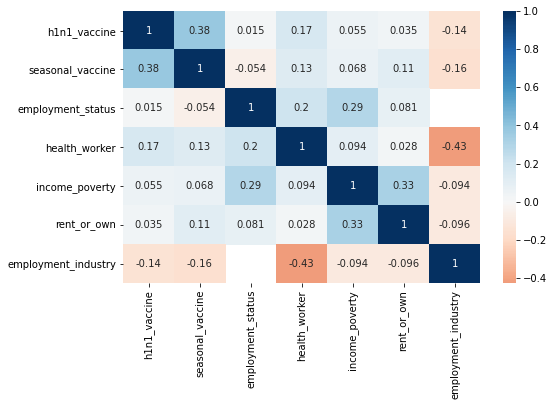

In [108]:
corr6 = raw_4[['h1n1_vaccine', 'seasonal_vaccine', 'employment_status', 'health_worker', 'income_poverty', 'rent_or_own', 'employment_industry']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr6, cmap='RdBu', annot=True, center=0)

<AxesSubplot:xlabel='h1n1_vaccine'>

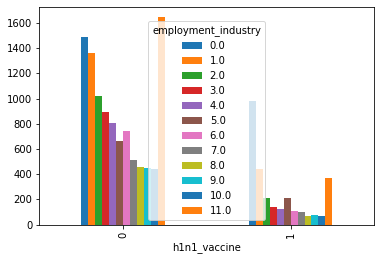

In [109]:
pd.crosstab(raw_4['h1n1_vaccine'],raw_4['employment_industry']).plot.bar()

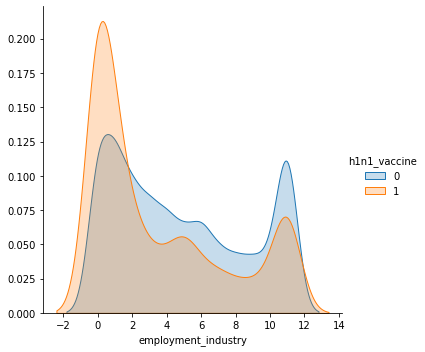

In [113]:
sns.FacetGrid(raw_4, hue='h1n1_vaccine',height=5).map(sns.kdeplot, 'employment_industry', shade=True).add_legend()

In [110]:
raw_4.groupby('h1n1_vaccine')['employment_industry'].describe()

,count,mean,std,min,25%,50%,75%,max
h1n1_vaccine,,,,,,,,
0,10474.0,4.854974,3.865996,0.0,1.0,4.0,8.0,11.0
1,2903.0,3.505339,3.945689,0.0,0.0,2.0,6.0,11.0


In [111]:
raw_4.groupby('seasonal_vaccine')['employment_industry'].describe()

,count,mean,std,min,25%,50%,75%,max
seasonal_vaccine,,,,,,,,
0,7715.0,5.085807,3.837022,0.0,2.0,4.0,9.0,11.0
1,5662.0,3.848463,3.926502,0.0,0.0,2.0,7.0,11.0


In [112]:
(raw_4.groupby('h1n1_vaccine')['employment_industry'].value_counts(normalize=True)*100)

h1n1_vaccine  employment_industry
0             11.0                   15.696009
              0.0                    14.187512
              1.0                    12.994081
              2.0                     9.728852
              3.0                     8.535421
              4.0                     7.657056
              6.0                     7.122398
              5.0                     6.329960
              7.0                     4.907390
              8.0                     4.353638
              9.0                     4.286805
              10.0                    4.200878
1             0.0                    33.827075
              1.0                    15.260076
              11.0                   12.745436
              2.0                     7.302790
              5.0                     7.165002
              3.0                     4.925939
              4.0                     4.271443
              6.0                     3.616948
              7.0         

In [114]:
raw_5 = raw_4

In [115]:
# save raw_5 full df as csv file for later use - modeling
raw_5.to_csv(r'df_5.csv')